# sparse coding notebook

In [1]:
import numpy as np
import theano 
import theano.tensor as T
import matplotlib.pyplot as plt
import math 
from scipy.io import loadmat 
from sklearn.feature_extraction.image import PatchExtractor
from theano.compat.python2x import OrderedDict
from utils import tile_raster_images as tri
%matplotlib inline

In [2]:
data = loadmat("IMAGES.mat")

In [3]:
ims = np.transpose(data['IMAGES'], (2,0,1))

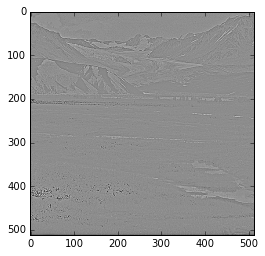

In [4]:
plt.imshow(ims[9], cmap = 'gray') 
plt.show()

In [5]:
shape = (8,8)
dim = np.prod(shape)
patches = PatchExtractor(shape, 64*64).transform(ims)
patches = patches.reshape(-1,dim).astype('float32')

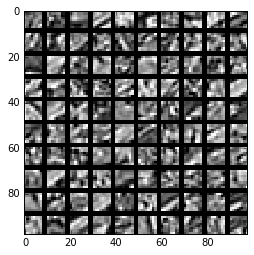

In [6]:
im = tri(patches[:100], shape, (10, 10), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')

In [7]:
patches.shape

(40960, 64)

# starting theano

In [8]:
n_batch = 100
n_iter = 150
epochs = 1
nneurons = 1*dim 

In [9]:
x = theano.shared(np.zeros((n_batch,dim)).astype('float32'))
w = theano.shared(np.random.randn(nneurons,dim).astype('float32'))
a = theano.shared(np.zeros((n_batch,nneurons)).astype('float32'))
x_batch = T.matrix() 

In [10]:
# 1 will change 
lam = .1 
eps_a = .01
eps_w = 1

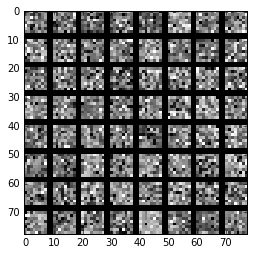

In [11]:
im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')

In [12]:
costfunction = (.5*(x-T.dot(a,w))**2).sum(axis=1).mean() + lam*abs(a).sum(axis=1).mean() 
grad_a = T.grad(costfunction,a) 
grad_w = T.grad(costfunction,w)

In [13]:
# first function will zero out the a's 
# step_a will begin gradiant descent on a
# step_w will begin gradient descent on w 
updates = OrderedDict()
updates[a] = 0.*a 
zero_a = theano.function([],[],updates = updates)

updates = OrderedDict()
updates[a] = a - eps_a*grad_a 
step_a = theano.function([],[costfunction],updates = updates)
    
updates = OrderedDict()
updates[x] = x_batch
update_x = theano.function([x_batch],[],updates = updates)

updates = OrderedDict()
updates[w] = w - eps_w*grad_w 
step_w = theano.function([],[costfunction],updates = updates) 

# Train the model

In [14]:
for kk in range(epochs):
    for ii in range(int(math.floor(1.*patches.shape[0]/n_batch))):
        zero_a()
        update_x(patches[ii*n_batch : (ii+1)*n_batch])
        for jj in range(n_iter):
            cost = step_a() 
            #print cost
        step_w()
   # plt.figure()
   # im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
   # plt.imshow(im, cmap='gray', interpolation='nearest')

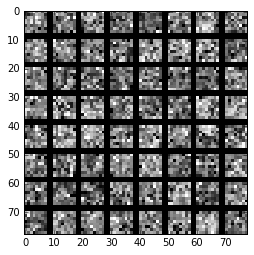

In [25]:
im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')